In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Define spin-1 operators (Sx, Sy, Sz) for the AKLT model
X = np.sqrt(1/2) * np.array([[0, 1, 0],
                             [1, 0, 1],
                             [0, 1, 0]], dtype=np.complex128)

Y = (-1j * np.sqrt(1/2) * np.array([[0, 1, 0],
                                    [-1, 0, 1],
                                    [0, -1, 0]], dtype=np.complex128))

Z = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, -1]], dtype=np.complex128)


def construct_chain(N, operator1, operator2, pos):
    """
    Embed the given operator at positions `pos` and `pos + 1` in an N-spin chain.
    All other positions are filled with identity matrices.

    Parameters:
        N (int): Number of spins in the chain.
        operator (np.ndarray): Operator to embed (e.g., X, Y, Z).
        pos (int): The starting position for the operator (acting on spins pos and pos + 1).

    Returns:
        np.ndarray: The resulting full-chain matrix.
    """
    # Build a list of identity matrices for each site
    a_chain = [np.eye(3, dtype=np.complex128) for _ in range(N)]
    
    # Replace at positions pos and pos + 1 with the operator
    a_chain[pos] = operator1
    a_chain[pos + 1] = operator2

    # Take Kronecker product across the full chain
    result = a_chain[0]
    for ii in range(1, N):
        result = np.kron(result, a_chain[ii])
    
    return result


def scalar_product(N, i):
    """
    Compute the scalar product S_i · S_{i+1} for spin-1 operators 
    at positions i and i + 1 in the chain.

    Parameters:
        N (int): Number of spins.
        i (int): Site index for S_i.

    Returns:
        np.ndarray: The matrix representing S_i · S_{i+1}.
    """
    return (
        construct_chain(N, X, X, i) +
        construct_chain(N, Y, Y, i) +
        construct_chain(N, Z, Z,  i)
    )


def Hamiltonian(N):
    """
    Construct the AKLT Hamiltonian for an N-spin chain:
    H = Σ_i [ S_i · S_{i+1} + (1/3)*(S_i · S_{i+1})² ]

    Parameters:
        N (int): Number of spins.

    Returns:
        np.ndarray: The full Hamiltonian matrix (size 3^N × 3^N).
    """
    H = np.zeros((3**N, 3**N), dtype=np.complex128)
    
    for ii in range(N - 1):  # Loop over neighboring pairs
        SdotS = scalar_product(N, ii)
        H += SdotS + (1/3)*(SdotS @ SdotS)
    
    return H

The operator $\vec{S}^i$ is defined as the collection of operators $(S^i_x, S^i_y, S^i_z)$

The total squared spin operator is $\mathbf{S}^2\equiv(\sum\;\vec{S}^i)^2$ with eigenvalues given by $l(l+1)$ in the code S_T = np.zeros((3N, 3N, 3), dtype=np.complex128) creates a 3D array to store the three components (Sx, Sy, Sz) each component is a $3^N\times 3^N$ matrix

For each spin component (X, Y, Z)

- creates a local operator at each site l
- builds the full operator via Kronecker products
- sums over all sites to get the spin operator

Then computes $S^2= S_x^2+S^2_y+S^2_z$

Finally compute the expectation values $\langle \psi|S_z|\psi\rangle$ and $\langle \psi|S^2|\psi\rangle$

where $\psi$ are the eigenvectors found diagonalizing the full Hamiltonian matrix

In [3]:
def total_spin_analysis_full_space(N, H, eigenvalues, eigenvectors):
    """
    Analyze total spin properties for ALL eigenstates of the Hamiltonian.
    
    Args:
        N (int): Number of sites.
        H (np.ndarray): Full Hamiltonian matrix.
        eigenvalues (np.ndarray): Eigenvalues of H.
        eigenvectors (np.ndarray): Eigenvectors of H (columns).
    
    Returns:
        tuple: (S_z_values, S_squared_values, energies) for all eigenstates.
    """
    # Initialize total spin operators (Sx, Sy, Sz)
    S_T = np.zeros((3**N, 3**N, 3), dtype=np.complex128)
   
    
    # Build total spin operators Sx, Sy, Sz
    for j, op in enumerate([X, Y, Z]):
        S_Tj = np.zeros((3**N, 3**N), dtype=np.complex128)
        for l in range(N):
            op_chain = [np.eye(3)] * N
            op_chain[l] = op
            S_l = op_chain[0]
            for i in range(1, N):
                S_l = np.kron(S_l, op_chain[i])
            S_Tj += S_l
        S_T[:, :, j] = S_Tj
    
    # Total spin squared operator (S^2 = Sx^2 + Sy^2 + Sz^2)
    S_Tsq = sum(S_T[:, :, j] @ S_T[:, :, j] for j in range(3))
    S_Tsq = 0.5 * (S_Tsq + S_Tsq.conj().T)  # Ensure Hermiticity
    
    # Sz operator (already Hermitian)
    S_Tz = S_T[:, :, 2]
    
    # Compute expectation values for all eigenstates
    num_states = eigenvectors.shape[1]
    S_z_values = np.zeros(num_states)
    S_squared_values = np.zeros(num_states)
    
    for s in range(num_states):
        state = eigenvectors[:, s]
        S_z_values[s] = np.real(state.conj().T @ S_Tz @ state)
        S_squared_values[s] = np.real(state.conj().T @ S_Tsq @ state)
    
    return S_z_values, S_squared_values, eigenvalues

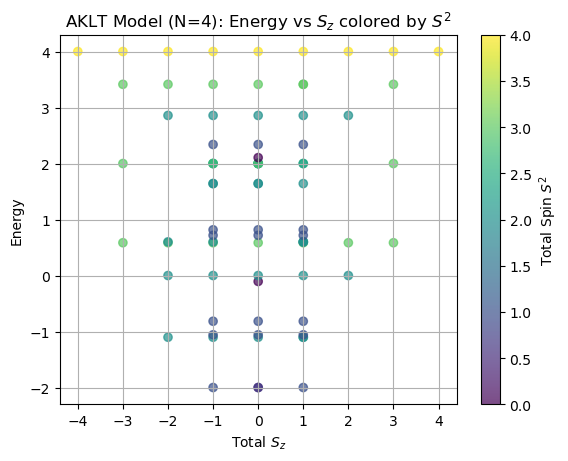

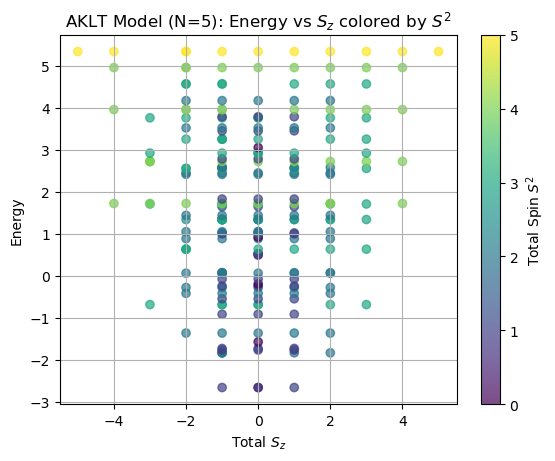

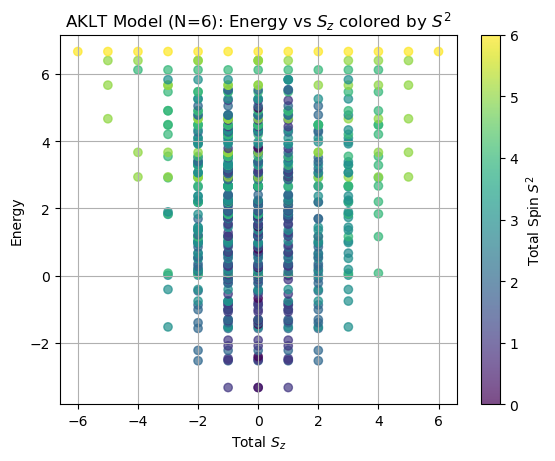

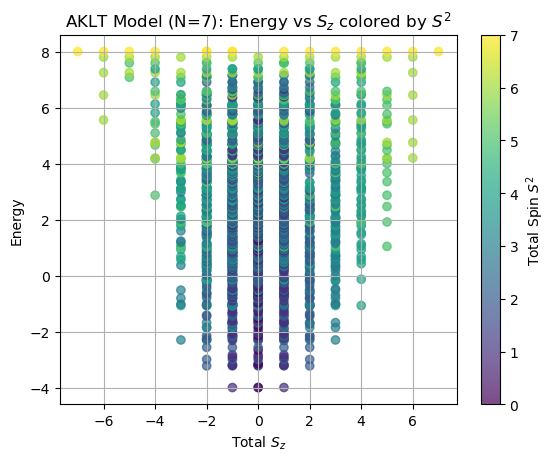

In [5]:
Ns= [4, 5, 6, 7]
for N in Ns:

    H= Hamiltonian(N)
    eigenvalues, eigenvectors = np.linalg.eigh(H)  # H is your full AKLT Hamiltonian
    
    S_z_values, S_squared_values, energies = total_spin_analysis_full_space(N, H, eigenvalues, eigenvectors)
    
    S_z_rounded = np.round(S_z_values)
    
    # Compute total spin S from S^2: S = (sqrt(4*S_squared + 1) - 1)/2
    S_values = (np.sqrt(4 * S_squared_values + 1) - 1) / 2
    
    
    # Plot with color-coding by S
    plt.scatter(S_z_rounded, energies, c=S_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Total Spin $S^2$')
    plt.xlabel('Total $S_z$')
    plt.ylabel('Energy')
    plt.title(f'AKLT Model (N={N}): Energy vs $S_z$ colored by $S^2$')
    plt.grid()
    plt.show()

